/Users/liang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/var/folders/5q/hsstlp7j3l938jzp0krtjh7w0000gn/T/ipykernel_40146/1769819007.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b['user_level']= 'B'
/var/folders/5q/hsstlp7j3l938jzp0krtjh7w0000gn/T/ipykernel_40146/1769819007.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['user_level']='A'


[Text(0, 0, 'Order Amount'), Text(1, 0, 'Order Number')]

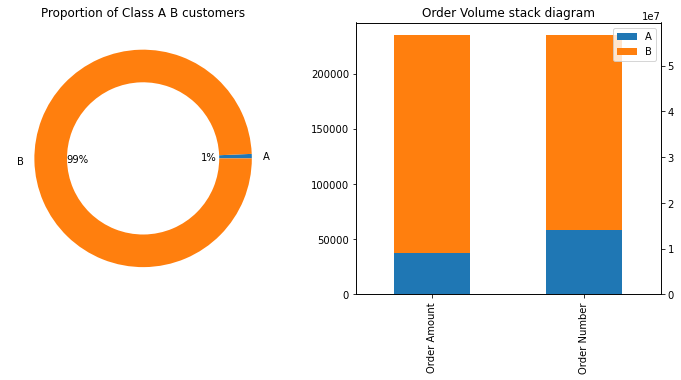

In [3]:
import pandas as pd
import numpy as np
df_path = r'Sales of electronic products.xlsx'
df_u = pd.read_excel(df_path)

df_u.fillna('no_brand',inplace = True)
df_u = df_u.drop_duplicates('order_id')
df_u['event_time'] = pd.to_datetime(df_u['event_time']).dt.to_period('D')
df_u = df_u.set_index('event_time',drop = False)
df_u['month'] = df_u['event_time'].dt.month

df = df_u
user_record=df.groupby('user_id')['order_id'].count().sort_values(ascending=False)
df_b = df.loc[df['user_id'].isin(user_record[user_record<30].index)]
df_b['user_level']= 'B'
df_a=df.loc[~df['user_id'].isin(list(df_b['user_id']))]
df_a['user_level']='A'
df_ab = pd.concat([df_a,df_b])

import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,2 ,figsize=(12,5))
df_ab.groupby('user_level')['user_id'].nunique().plot(kind='pie',title='Proportion of Class A B customers',ax=axs[0],autopct='%.0f%%',ylabel='',wedgeprops={'width':0.3})
ax1 = pd.concat([pd.DataFrame({'A':[0]}),df_ab.groupby('user_level').agg({'order_id':pd.Series.count}).T],axis=0).plot(kind = 'bar',legend=False,ax=axs[1],stacked=True,xlabel='',title='Order Volume stack diagram')
pd.concat([df_ab.groupby('user_level').agg({'price':np.sum}).T,pd.DataFrame({'A':[0]})],axis=0).plot(kind = 'bar',ax=ax1.twinx(),stacked=True,xlabel='').set_xticklabels(['Order Amount','Order Number'])

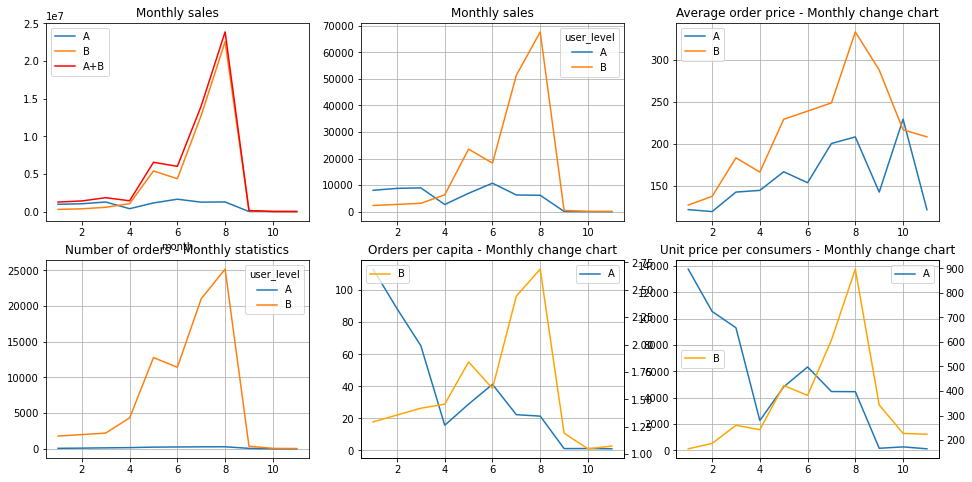

In [4]:
fig,axs = plt.subplots(2,3,figsize= (16,8))
df_ab.groupby(['month','user_level'])['price'].sum().unstack().plot(grid=True,title='Monthly sales',xlabel='',ax=axs[0,0])
df_ab.groupby('month')['price'].sum().rename('A+B').plot(ax=axs[0,0],color='r').legend(loc=2)
df_ab.groupby(['month','user_level'])['order_id'].count().unstack().plot(grid=True,title='Monthly sales',xlabel='',ax=axs[0,1])
(df_a.groupby('month')['price'].sum()/df_a.groupby('month')['order_id'].count()).rename('A').plot(xlabel='',ax=axs[0,2])
(df_b.groupby('month')['price'].sum()/df_b.groupby('month')['order_id'].count()).rename('B').plot(grid=True,title='Average order price - Monthly change chart',xlabel='',ax=axs[0,2]).legend(loc=2)
df_ab.groupby(['month','user_level']).user_id.nunique().unstack().plot(grid=True,title='Number of orders - Monthly statistics',xlabel='',ax=axs[1,0])
ax2 = (df_a.groupby('month')['order_id'].count()/df_a.groupby('month').user_id.nunique()).rename('A').plot(grid=True,xlabel='',ax=axs[1,1],legend=1)
(df_b.groupby('month')['order_id'].count()/df_b.groupby('month').user_id.nunique()).rename('B').plot(title='Orders per capita - Monthly change chart',xlabel='',ax=ax2.twinx(),color='orange').legend(loc=2)
ax1 = (df_a.groupby('month')['price'].sum()/df_a.groupby('month').user_id.nunique()).rename('A').plot(grid=True,xlabel='',ax=axs[1,2],legend=1)
(df_b.groupby('month')['price'].sum()/df_b.groupby('month').user_id.nunique()).rename('B').plot(title='Unit price per consumers - Monthly change chart',xlabel='',ax=ax1.twinx(),color='orange').legend(loc=6)

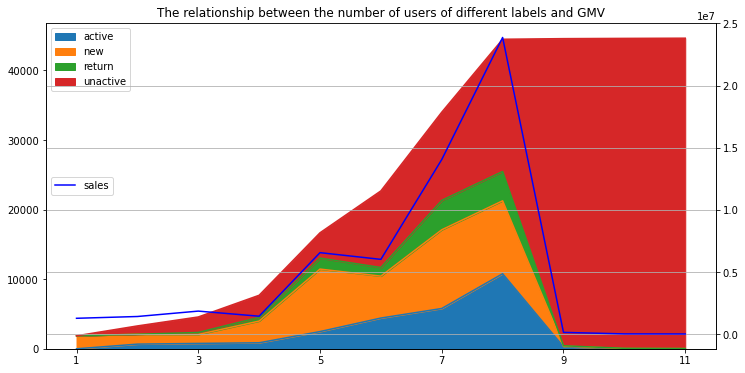

In [5]:
def active_status(x):
    status = []
    for i in range(11):
        if x[i] == 0:
            if i == 0:
                status.append('unreg')
            else :
                status.append('unreg') if status[i-1] == 'unreg' else  status.append('unactive')            
        else:
            if i == 0:
                status.append('new')
            else:
                if status[i-1] == 'unreg':
                    status.append('new') 
                else:
                    status.append('return') if status[i-1]=='unactive' else status.append('active')
    return pd.Series(status,index = columns_month)
columns_month = df['month'].sort_values().astype('str').unique()
order_record = df.pivot_table(index = 'user_id',columns='month',values ='price',aggfunc='sum').fillna(0).applymap(lambda i: 1 if i>0 else 0)
order_record.columns = df['month'].sort_values().astype('str').unique()
user_active_status = order_record.apply(active_status,axis = 1)
ax1= user_active_status.apply(lambda x: pd.value_counts(x)).drop('unreg').fillna(0).T.plot(kind='area',figsize=(12,6))
df_ab.groupby([df_ab['event_time'].dt.month])['price'].sum().rename('sales').plot(ax=ax1.twinx(),grid=True,color='b',title='The relationship between the number of users of different labels and GMV',xlabel='',use_index=False).legend(loc=6)

<AxesSubplot:title={'center':'The proportion of the top 10 orders of Class B customers'}>

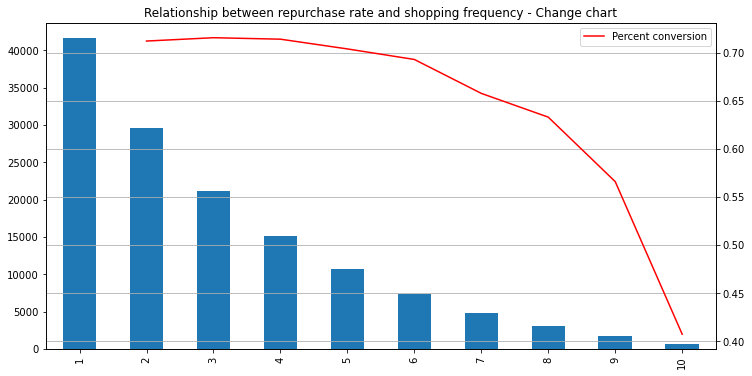

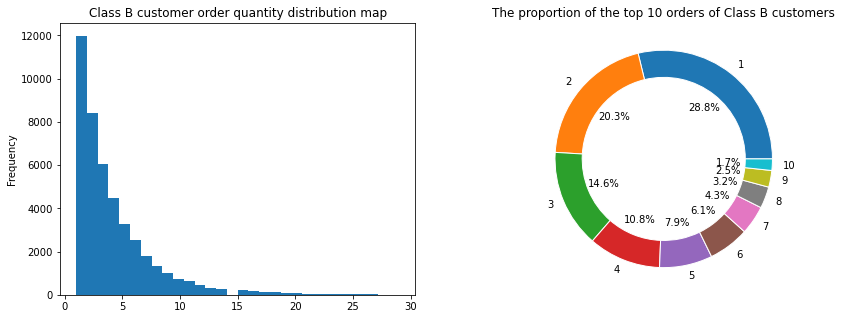

In [6]:
order_totll = df_b.groupby('user_id').agg({'order_id':pd.Series.count,'price':np.max}).groupby('order_id')['price'].count().head(10)
order_fq=[]
for i in range(10):
    a=order_totll.iloc[i:].sum()
    order_fq.append(a)
order_fq = pd.Series(order_fq,index=list(range(1,11)))
ax1 = order_fq.head(10).plot(kind='bar',figsize=(12,6),xlabel='')
(order_fq.pct_change(periods=1)+1).rename('Percent conversion').plot(use_index=False,color='r',title='Relationship between repurchase rate and shopping frequency - Change chart',grid=True,ax=ax1.twinx(),legend=1)

fig,axs = plt.subplots(1,2 ,figsize=(14,5))
df_b.groupby('user_id')['order_id'].count().plot(kind='hist',bins=30,ax=axs[0],title ='Class B customer order quantity distribution map')
order_totll.plot(wedgeprops={'width':0.25,'edgecolor':'w'},ylabel='',kind='pie',autopct='%.1f%%',ax=axs[1],title ='The proportion of the top 10 orders of Class B customers')

<AxesSubplot:title={'center':'Second order Interval - Histogram (days)'}, ylabel='Frequency'>

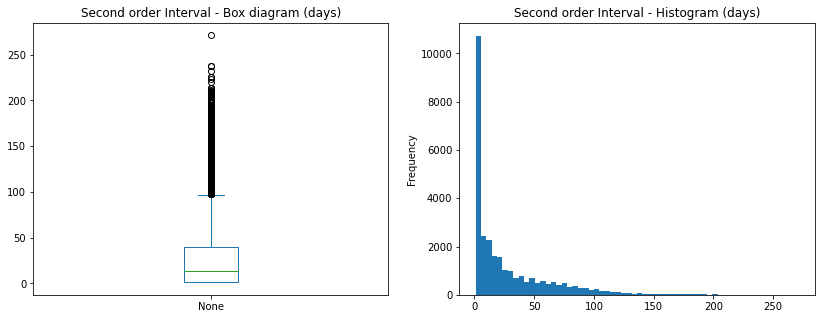

In [7]:
order_2b = df_b[['user_id','event_time','order_id']].reset_index(drop = True)
order_2b = order_2b.groupby(by=['user_id','event_time'],as_index=False)['order_id'].count()
order_2b = order_2b.pivot_table(index='user_id',columns='event_time',values='order_id').fillna(0)

def data_count(x): 
    fig =0
    for i in range(len(x)):
        if x.iloc[i] !=0:
            if fig!=1 :
                fig+=1 
                a=i
            else:
                a=i-a
                return a
second_order =order_2b.apply(data_count,axis=1) 

fig,axs = plt.subplots(1,2,figsize=(14,5))
second_order.plot(kind="box",title='Second order Interval - Box diagram (days)',ax=axs[0])
second_order.plot(kind="hist",title='Second order Interval - Histogram (days)',ax=axs[1],bins=60)

<AxesSubplot:title={'center':'B Members - Type distribution'}>

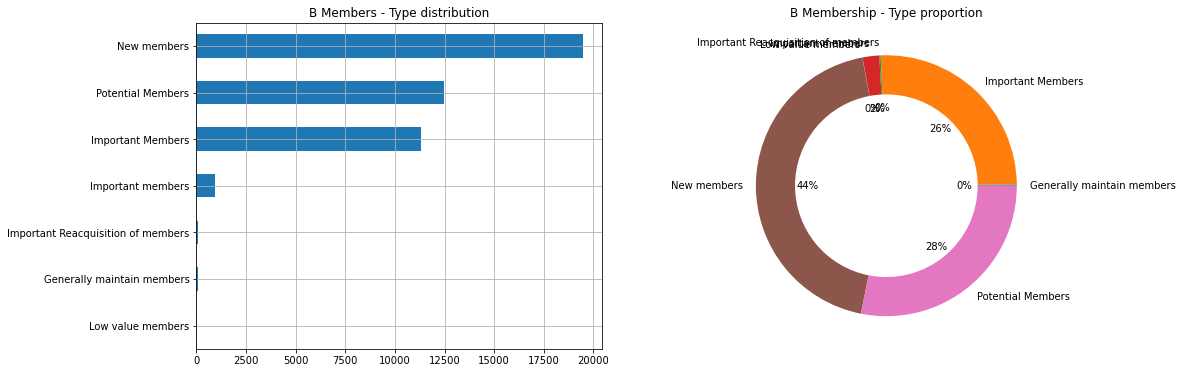

In [11]:
import re
b_r = df_b.groupby('user_id')['event_time'].min().map(lambda i : pd.to_datetime('2020-11-21').to_period('D')-i)
R = b_r.astype('str').map(lambda i: re.compile(r'\d*').findall(i)[1])
R.loc[b_r.astype('str').map(lambda i: re.compile(r'\d*').findall(i)[1])=='']=1
R = R.astype('int32')
F = df_b.groupby('user_id')['order_id'].count()
M = df_b.groupby('user_id')['price'].sum()

def RFM(x):
    r='1' if x[0]<= 30 else '0' # The most recent shopping days are less than 30 days
    f='1' if x[1]>= 3 else '0'  # Cumulative shopping times greater than 2 (average)
    m='1' if x[2]>=1257 else '0' # Cumulative consumption amount greater than 1257 (average)
    return dic_rfm[r+f+m]
dic_rfm ={
    '111':'Important Members',
    '011':'Important Reacquisition of members',
    '101':'Important members',
    '001':'Important retention member',
    '110':'Potential Members',
    '100':'New members',
    '010':'Generally maintain members',
    '000':'Low value members'}

b_rfm = pd.concat([R,F,M],axis=1).apply(RFM,axis=1)
B_RFM = pd.concat([b_rfm.map(lambda i: i.split('：')[0]).rename('Membership type'),b_rfm.map(lambda i: i.split('：')[-1]).rename('Marketing strategies')],axis=1)

fig,axs = plt.subplots(1,2,figsize=(16,6))
B_RFM.groupby('Membership type')['Marketing strategies'].count().plot(kind='pie',title='B Membership - Type proportion',autopct='%.0f%%',ax=axs[1],wedgeprops={'width':0.3},ylabel='')
B_RFM.groupby('Membership type')['Marketing strategies'].count().sort_values().plot(kind='barh',title='B Members - Type distribution',xlabel='',ax=axs[0],grid=1)